### **StateGraph로 상태 만들기**

In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph

class State(TypedDict):
    counter: int
    alphabet: list[str]

graph_builder = StateGraph(State)

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
import operator

class State(TypedDict):
    counter: int
    alphabet: list[str]

def node_a(state: State):
    state['counter'] += 1
    state['alphabet']= ["Hello"]
    return state

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", node_a)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

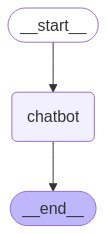

In [3]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [4]:
# 초기 상태 정의
initial_state = {
    "counter": 0,
    "alphabet": []
}

state = initial_state

for _ in range(3):
    state = graph.invoke(state)
    print(state)

{'counter': 1, 'alphabet': ['Hello']}
{'counter': 2, 'alphabet': ['Hello']}
{'counter': 3, 'alphabet': ['Hello']}


In [5]:
class State(TypedDict):
    counter: int
    alphabet: Annotated[list[str], operator.add]

def node_a(state: State):
    state['counter'] += 1
    state['alphabet']= ["Hello"]
    return state

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", node_a)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

In [6]:
# 초기 상태 정의
initial_state = {
    "counter": 0,
    "alphabet": []
}

state = initial_state

for _ in range(3):
    state = graph.invoke(state)
    print(state)

{'counter': 1, 'alphabet': ['Hello']}
{'counter': 2, 'alphabet': ['Hello', 'Hello']}
{'counter': 3, 'alphabet': ['Hello', 'Hello', 'Hello']}


### **Message를 담는 StateGraph 만들기**

In [7]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOpenAI(model="gpt-4o-mini")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

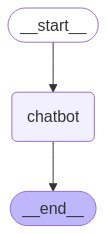

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: 안녕하세요! 어떻게 도와드릴까요?
Goodbye!


In [10]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState

graph_builder = StateGraph(MessagesState)

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

In [11]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: 안녕하세요! 어떻게 도와드릴까요?
Goodbye!


In [13]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState

class State(MessagesState):
    counter: int
    
graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    state['counter'] = state.get('counter', 0) + 1
    return {
        "messages": [llm.invoke(state["messages"])],
        "counter":state['counter']
           }

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

In [14]:
from langchain_core.messages import HumanMessage

# 초기 상태 설정
initial_state = {
    "messages": [HumanMessage(content="Hello!")],
    "counter": 0
}

# 그래프 실행
result = graph.invoke(initial_state)

print(f"Final state: {result}")

Final state: {'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='1faacf1d-4175-4276-b4b1-0c83cf7cffde'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'finish_reason': 'stop', 'logprobs': None}, id='run-6bc548a2-6914-4051-949f-f75493e1b1c7-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})], 'counter': 1}


In [15]:
state = initial_state
for _ in range(3):
    state = graph.invoke(state)
    print(f"Counter: {state['counter']}")
    print(f"Last message: {state['messages'][-1].content}")
    print("---")

Counter: 1
Last message: Hello! How can I assist you today?
---
Counter: 2
Last message: Hello! How can I assist you today?
---
Counter: 3
Last message: Hello! How can I assist you today?
---
